<h1 style="text-align:center;">Building makemore (V) : Building a WaveNet</h1>


WaveNet is a deep learning architecture primarily used for generating raw audio waveforms, developed by researchers at DeepMind. It employs a deep neural network with convolutional layers to model the conditional probability distribution of audio samples given previous samples. WaveNet is notable for its ability to generate high-fidelity audio with fine-grained control over characteristics like pitch, duration, and timbre. It has applications in speech synthesis, music generation, and audio processing tasks.

![alt](wavenet.webp)

Useful links :

- [WaveNet 2016 paper from DeepMin](https://arxiv.org/pdf/1609.03499.pdf)
- [Bengio et al. 2003 MLP language model paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Loading the data


In [23]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(f"The total number of words : {len(words)}")
print(f"The longest word has {max(len(w) for w in words)} charachters")
print(f"The 8 first words are : {words[:8]}")

The total number of words : 32033
The longest word has 15 charachters
The 8 first words are : ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [24]:
chars = sorted(list(set(''.join(words))))
print(f"The length of chars is {len(chars)}")

# Encoder : convert string to integer
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
print(f"The encoder (string to integer) that we're going to work with is :\n{stoi}\n")

# Decoder : convert integer to string
itos = {i:s for s,i in stoi.items()}
print(f"The decoder (integer to string) that we're going to work with is :\n{itos}")

# Vocabulary size
vocab_size = len(itos)

print(f"The vocabulary of size {len(itos)} we're working with is :\n{itos.values()}\n")

The length of chars is 26
The encoder (string to integer) that we're going to work with is :
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}

The decoder (integer to string) that we're going to work with is :
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
The vocabulary of size 27 we're working with is :
dict_values(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.'])



# Building the dataset

In [25]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one? (T : time dimension)

def build_dataset(words):
    """Takes a list of some words and builds the arrays X and Y
    for those words only"""
    
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size   # initial context is 8 dots '........'
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    # convert the lists into toch tensors
    X = torch.tensor(X)    # contexts
    Y = torch.tensor(Y)    # indexes of the ground truths
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(42)
random.shuffle(words)      # Shuffling the words
n1 = int(0.8*len(words))   # length of the training data (80%)
n2 = int(0.9*len(words))   # length of validation data (10%), and the remaigning 10% is for testing

# Building training, validation and testing datasets
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


Let's take a look at the first 20 examples, where each example has a context length of 8 :

In [26]:
for x,y in zip(Xtr[:20], Ytr[:20]) :
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


# Building the classes

In the next section, we're going to build our model, but first, we are going to "Pytorchify" the code by making it a little bit more simalar to Pytorchby, by building classes of the layers we're going to use in the model.

In [27]:
# Near copy paste of the layers we have developed in Part (III)

# -----------------------------------------------------------------------------------------------
class Linear: # similar to 'torch.nn.Linear' class representing a linear transformation layer
    
    def __init__(self, fan_in, fan_out, bias=True):
        # initializations :
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init weight matrix is of shape (fan_in, fan_out)
        self.bias = torch.zeros(fan_out) if bias else None  # shape (fan_out)
  
    def __call__(self, x):
        self.out = x @ self.weight # (x.shape[0], 'x.shape[1]=fan_in') @ (fan_in,fan_out) -----> (x.shape[0],fan_out)
        if self.bias is not None:
            self.out += self.bias #(x.shape[0],fan_out) + (fan_out)----broadcasting--->(x.shape[0],fan_out) + (x.shape[0],fan_out)----> (x.shape[0],fan_out)
        return self.out   #(x.shape[0],fan_out)

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])



# -----------------------------------------------------------------------------------------------
class BatchNorm1d:  # similar to 'torch.nn.BatchNorm1d' class representing a batch normalization layer designed for 1-dimensional input.
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps                             #  epsilon : a value added to the denominator for numerical stability
        self.momentum = momentum                   # the value used for the 'running_mean' and 'running_var' computation
        self.training = True                       # if we're training = True, otherwise = False
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)               # BN gain : dim is number of neurones in the previous hidden layer
        self.beta = torch.zeros(dim)               # BN bias
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training :   # during training
            if x.ndim == 2:
                dim = 0   # calculate mean and var by the 1st dimension
            elif x.ndim == 3:
                dim = (0,1)  # calculate mean and var rows (1st and 2nd dimensions)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else : # during evaluation or inference (self.training = False)
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(self.eps + xvar) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training: # during training
            with torch.no_grad(): # disabling gradient computation for 'running_mean' and 'running_var'
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out


    def parameters(self):
        return [self.gamma, self.beta]



# -----------------------------------------------------------------------------------------------
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []



# -----------------------------------------------------------------------------------------------
class Embedding: # similar to 'torch.nn.Embedding'  a class representing a module used for embedding categorical variables into continuous vector representations
    
    def __init__(self, num_embeddings, embedding_dim):  #'embedding_dim' is 'n_embd'
        self.weight = torch.randn((num_embeddings, embedding_dim)) #shape(num_embeddings, embedding_dim)
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out   # shape(embedding_dim)

    def parameters(self):
        return [self.weight]



#-----------------------------------------------------------------------------------------------
class FlattenConsecutive:  # Flattening layer to concatenate  the vectors representing each example from the batch 
    
    def __init__(self, n):
        self.n = n     # number consecutive elements to be flatten
    
    def __call__(self, x):
        
        B, T, C = x.shape   # B : 'batch_size',  T : 'context_size' or 'block_size' (time dimension), C : 'embedding_dim' (channel dimension)
        x = x.view(B, T//self.n, C*self.n)  # Each step we flatten n consecutive elements of x from the 2nd dimension into the 3rd dimension
        if x.shape[1] == 1:
            x = x.squeeze(1)   # squeeze the 2nd dimension : if [2, 1, 2] ----> [2,2]
        self.out = x
        return self.out # shape(B, T//self.n, C*self.n) or shape(B, C*self.n) 
  
    def parameters(self):
        return []



#-----------------------------------------------------------------------------------------------
class Sequential: # similar to 'torch.nn.Sequential' a class representing a container module. It allows to stack multiple layers/modules sequentially
    
    def __init__(self, layers): # 'layers' represent here is a list of layers
        self.layers = layers
  
    def __call__(self, x):
        for layer in self.layers :
            x = layer(x)  #  the __call__ methods from the different layers defined above are applied sequentially on x
        self.out = x
        return self.out
  
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]


# Building the model

In [28]:
torch.manual_seed(42); # seed rng for reproducibility

In [29]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

In [30]:
# MLP STRUCTURE :
## EMBEDDING LAYER : vocab_size ----> (B,T,C) = (batch_size, block_size, n_embd)
## 1st FLATTENCONSECUTIVE(2) : (B, T, C) ----> (B, T//2, C*2)
## 1st LINEAR : (B, T//2, C*2) @ (C*2, n_hidden)---->(B, T//2, C*2) @ (B, C*2, n_hidden)---> (B,T//2,n_hidden)
## 1st BN1d & Tanh : (B,T//2,n_hidden) ---> (B,T//2,n_hidden)----> (B,T//2,n_hidden)
## 2nd FLATTENCONSECUTIVE(2) : (B,T//2,n_hidden) ----> (B, T//4, n_hidden*2)
## 2nd LINEAR : (B, T//4, n_hidden*2) @ (n_hidden*2, n_hidden) ---> (B, T//4, n_hidden*2) @ (B, n_hidden*2, n_hidden)---> (B, T//4, n_hidden)
## 2nd BN1d & tanh : (B, T//4, n_hidden) ---> (B, T//4, n_hidden)---> (B, T//4, n_hidden)
## 3rd FLATTENCONSECUTIVE(2): (B, T//4, n_hidden) ----> (B, T//8, n_hidden*2)
## 3rd LINEAR : (B, T//8, n_hidden*2) @ (n_hidden*2, n_hidden) ----> (B, T//8, n_hidden*2) @ (B, n_hidden*2, n_hidden)-->(B, T//8, n_hidden)
## 3rd BN1d & tanh : (B, T//8, n_hidden) ----> (B, T//8, n_hidden)----> (B, T//8, n_hidden)
## 4th LINEAR (output) : (B, T//8, n_hidden) @ (n_hidden, vocab_size)--> (B, T//8, n_hidden) @ (B, n_hidden, vocab_size)-->(B, T//8, vocab_size)


# hierarchical network : it's like bacthes of batches
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in each hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
]) 

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # making the last layer (output) less confident

# model's parameters 
parameters = model.parameters()

# number of parameters in total
print(sum(p.nelement() for p in parameters)) 
for p in parameters:
    p.requires_grad = True

76579


**(B,T,C) :**
    
 - **B :** Batch dimension. It represents the number of samples or data points processed simultaneously in a single forward or backward pass through the neural network. Each sample in the batch typically corresponds to an independent input instance.
 
 - **T :** Time dimension. It represents the length or number of time steps in a sequence. This dimension is often associated with sequential data, such as time series or text, where each time step corresponds to a specific point in time or position in the sequence.
 
 - **C :** Channel dimension. It represents the number of channels or features at each time step. In image data, for example, each channel could represent a color channel (e.g., red, green, blue) or a feature map extracted by a convolutional layer.

# Training the model

In [38]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []  # list containing the computed loss after each iteration i

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) # return 32 nbs between 0 and Xtr.shape[0]
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y : extracting 32 rows from X, and 32 elements from Y
  
    # forward pass
    logits = model(Xb)  # applying the model
    loss = F.cross_entropy(logits, Yb) # loss function
  
    # backward pass
    for p in parameters:
        p.grad = None  # set the grad to zero in Pytorch
    loss.backward()
  
    # update: simple SGD (Stochastic Gradient Descent)
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3167
  10000/ 200000: 2.0576
  20000/ 200000: 2.0723
  30000/ 200000: 2.5134
  40000/ 200000: 2.1476
  50000/ 200000: 1.7836
  60000/ 200000: 2.2592
  70000/ 200000: 1.9331
  80000/ 200000: 1.6875
  90000/ 200000: 2.0395
 100000/ 200000: 1.7736
 110000/ 200000: 1.9569
 120000/ 200000: 1.7465
 130000/ 200000: 1.8126
 140000/ 200000: 1.7406
 150000/ 200000: 1.7466
 160000/ 200000: 1.8805
 170000/ 200000: 1.6266
 180000/ 200000: 1.6476
 190000/ 200000: 1.8555


Let's plot the losses obtained by the model versus the iterations :

In [39]:
torch.tensor(lossi).shape

torch.Size([200000])

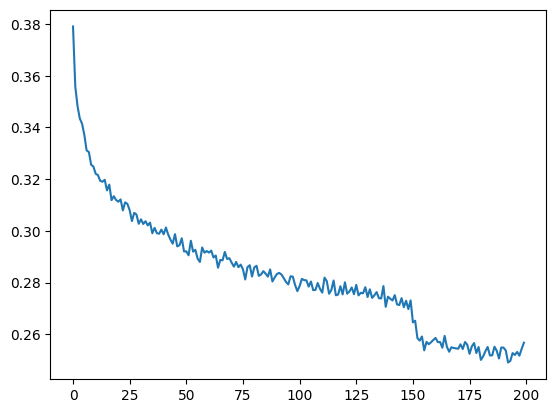

In [51]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))  # calculating the mean of lossi each 1000 steps

# Evaluating the model

First we put the layers into evaluation mode (needed for Batch Normalization especially)

In [41]:
for layer in model.layers:
    layer.training = False   # set training to false in evaluation and testing

In [42]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    """given the 'split' ('train' or 'val' or 'test') the function will apply the model
    on the given 'split' dataset and return the loss"""
        
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.769028902053833
val 1.9936511516571045


In [58]:
Xdev.shape

torch.Size([22655, 8])

In [56]:
for layer in model.layers :
    print(layer.__class__.__name__, "'s output :", tuple(layer.out.shape))

Embedding 's output : (1, 8, 24)
FlattenConsecutive 's output : (1, 4, 48)
Linear 's output : (1, 4, 128)
BatchNorm1d 's output : (1, 4, 128)
Tanh 's output : (1, 4, 128)
FlattenConsecutive 's output : (1, 2, 256)
Linear 's output : (1, 2, 128)
BatchNorm1d 's output : (1, 2, 128)
Tanh 's output : (1, 2, 128)
FlattenConsecutive 's output : (1, 256)
Linear 's output : (1, 128)
BatchNorm1d 's output : (1, 128)
Tanh 's output : (1, 128)
Linear 's output : (1, 27)


Notice that according the model we build, we have `B=1`, `T = block_size = 8` and `C = n_embd = 24`, after the third `FlattenConsecutive` layer since `T//8 = 1` the second dimension equal to 1 will be squeezed going from $(1,1,128)=>(1,128).$

### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


# Generating names

In [44]:
# sample from the model
for _ in range(20):   # 20 generated words
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

aiyanah.
giusopf.
lorron.
roger.
rhyitte.
christell.
jedmccee.
kelipson.
briyah.
sylot.
zennica.
mythan.
daxphon.
petrit.
adalie.
jeniyah.
glatipe.
manaswi.
yeslee.
stephania.


### Next time:
Why convolutions? Brief preview/hint

In [60]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [66]:
print(Xtr[7])
print(Xtr[[7]])

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([[0, 0, 0, 0, 0, 0, 0, 0]])


In [61]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [62]:
logits

tensor([[-6.1992,  2.1324,  0.7035,  0.8462,  0.9257,  0.8962, -0.4740, -0.1514,
          0.3707, -0.4270,  1.2310,  1.4139,  0.9954,  1.2296,  0.7075, -0.3372,
         -0.4053, -2.0900,  1.0720,  1.3119,  0.7226, -2.4925, -0.4803, -0.6256,
         -1.6393, -0.3046,  0.4911]], grad_fn=<AddBackward0>)

In [64]:
# forward all of them
logits = torch.zeros(8, 27)  # pre alocating some memory 
for i in range(8):
    logits[i] = model(Xtr[[7+i]]) # genrating letter by letter
logits.shape

torch.Size([8, 27])

In [65]:
logits

tensor([[-6.1992,  2.1324,  0.7035,  0.8462,  0.9257,  0.8962, -0.4740, -0.1514,
          0.3707, -0.4270,  1.2310,  1.4139,  0.9954,  1.2296,  0.7075, -0.3372,
         -0.4053, -2.0900,  1.0720,  1.3119,  0.7226, -2.4925, -0.4803, -0.6256,
         -1.6393, -0.3046,  0.4911],
        [-2.0451,  6.1436, -3.3007, -2.4050, -2.4362,  5.5334, -2.3488, -2.2467,
          2.6856,  4.0862, -0.2443, -3.3948, -0.5140,  2.4130,  0.4427,  4.1665,
         -3.5143, -4.2593,  3.6217,  0.1101, -4.2976,  2.7013,  0.7567,  0.8822,
         -3.5193,  2.4152, -1.9327],
        [-2.0515,  2.9153, -1.4507, -0.6272,  0.7754,  1.2553, -2.3827, -0.9021,
         -1.1156, -1.3823, -0.5744,  0.8473,  2.9489,  1.7160,  1.6271,  2.8599,
         -1.8846, -2.4968,  0.5958,  0.7054,  0.5962, -1.6562,  1.9487, -1.9058,
         -1.7698,  1.9910, -0.7634],
        [ 2.5460, -0.5013, -0.6957, -1.8096, -1.5929, -1.1960, -2.7979, -0.3748,
         -2.6381, -0.0702, -1.4247, -2.0187,  1.8558,  1.5591,  6.4173, -1.8837

In [48]:
# convolution is like a "for loop"
# it allows us to forward Linear layers efficiently over space

[Younes Dahami](https://www.linkedin.com/in/dahami/)